Hi, In this notebook I will illustrate the procedure of stabilization to see what happens.

As always, we start with some imports:

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode

I want to use a sample from the [LUNA16](https://luna16.grand-challenge.org/Data/) dataset. Here is the definition of a function to load ".mhd" and ".raw" files.

In [3]:
def _get_array_from_mhd_raw_file(path):
    ds = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(ds)
    return image


In [4]:
path = f'''/Users/mostafa/Desktop/dsb_analyse/input/subset0'''
file_path = f'{path}/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd'
img = _get_array_from_mhd_raw_file(path=file_path)
print(img.shape)

(133, 512, 512)


# Stabilization
Let's start the stabilization algorithm with fixed neighborhoods.

p.s: I've written this code in a way that you can pass "any" dimensional tensor as input of it.
Maybe for future work, we could pass all 3d-images captured by one particular device as one input so that they can share an initial alpha parameter as their global estimation (of course, we should think of its computational costs!). For now, I will use one 2d-image as input.

## Loading the image
I try to crop a rectangle from a slice of the 3d image. 

Also, I want each axis of the rectangle to be dividable to 35, 35 will be the size of each neighborhood for our image.

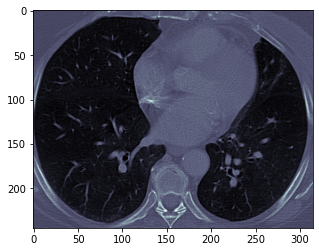

(245, 315)
Is it dividable to the neighborhoods size? True
-1024 -362.0585293164885 1794


In [5]:
data = img[70, 130:375, 115:430]
neighborhood_size=35
plt.imshow(data, cmap=plt.cm.bone)
plt.show()
print(data.shape)
print(f'Is it dividable to the neighborhoods size? {(data.shape[0] % neighborhood_size == 0) and (data.shape[1] % neighborhood_size == 0)}')
print(np.min(data), np.mean(data), np.max(data))

## Checking the distribution of the data

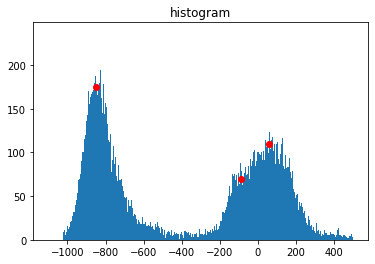

(245, 315)
-1024 -362.0585293164885 1794


In [6]:
flat = data.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(-850, 175, "or")
ax.plot(-90, 70, "or")
ax.plot(60, 110, "or")
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(data), np.mean(data), np.max(data))

Now I want to check the mode of the data:

In [7]:
print(mode(data, axis=None))

ModeResult(mode=array([-1024], dtype=int16), count=array([237]))


I wonder where these mode values are!

I want to replace their values with a big number to brighten the relating voxels in the image to see if they are scattered all around the image, or they appear intensely in one area.

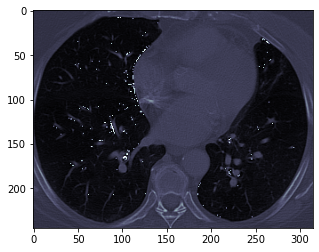

In [8]:
plt.imshow(np.where(data==-1024, 3000, data) , cmap=plt.cm.bone)
plt.show()

## Running the algorithm
OK, According to the histogram (specially the red dots), let's define our MU for J = 3 components:

/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_mixture_model.py:52: RuntimeWarning: invalid value encountered in log
  np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


iteration: 1, error: 0.00043389223222279965
iteration: 2, error: 0.0


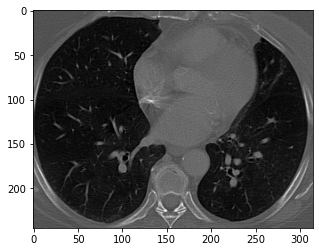

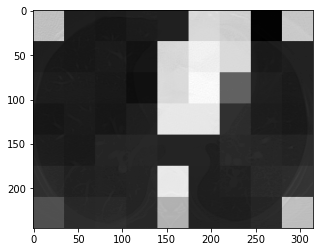

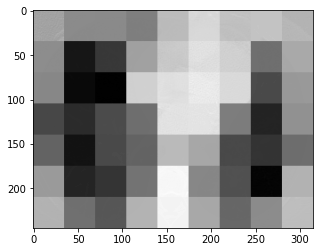

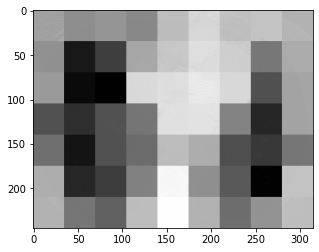

In [9]:
from ct_charachterization import run_third_algorithm


mu_3 = np.array([-870, -90, 50])
stabilized_y = run_third_algorithm(data, mu_3, non_central=True, constant_c=10, neighborhood_size=35)
plt.imshow(data, cmap='gray')
plt.show()
for j in range(len(mu_3)):
    sy = stabilized_y[..., j]
    plt.imshow(sy, cmap='gray')
    plt.show()



OK, in the second image above, something related to the lungs is visible. It belongs to the J=0 or the first component, which its mu is -870.

## Distribution of the result images
Let's checkout the distribution of the result images.

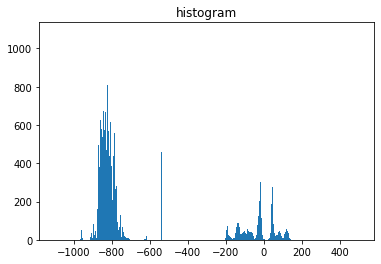

(245, 315)
-969.5135428629786 -641.9560552346262 148.9975921311625


In [11]:
flat = stabilized_y[..., 0].flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(flat), np.mean(flat), np.max(flat))

As you can see, the stabilization has decreased the effect of values far from mu = -870 in the distribution. (compare with the previous histogram)

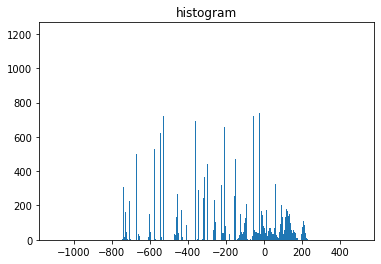

(245, 315)
-743.8203799277562 -227.63768947547072 242.59079254855942


In [12]:
flat = stabilized_y[..., 1].flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(flat), np.mean(flat), np.max(flat))

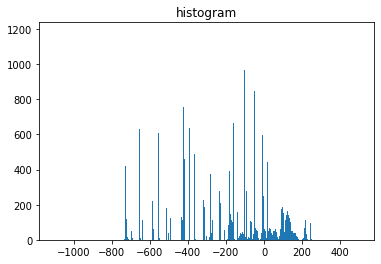

(245, 315)
-734.5635367425648 -198.98790532870242 249.49947605251919


In [13]:
flat = stabilized_y[..., 2].flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(flat), np.mean(flat), np.max(flat))

OK, after comparing these two histograms, you can find out that around their MUs (-90 and 50), distribution is denser than the other values.

Now I'm going to try the 3d-image with 3d-neighborhood of size 7\*7\*7 to see what happens.

# Exact the same procedure with a 3D image

I will take a patch of the sample, which its shape is (35, 245, 315).

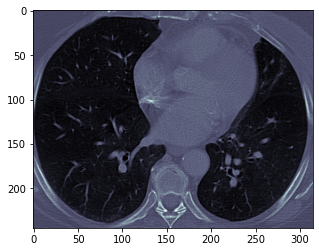

(35, 245, 315)
Is it dividable to the neighborhoods size? True
-1024 -292.72417344624927 3071


In [22]:
data = img[50:85, 130:375, 115:430]
neighborhood_size=7
plt.imshow(data[20, :, :], cmap=plt.cm.bone)
plt.show()
print(data.shape)
print(f'Is it dividable to the neighborhoods size? {(np.array(data.shape) % neighborhood_size == 0).all()}')
print(np.min(data), np.mean(data), np.max(data))

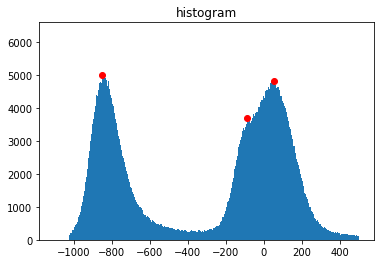

(35, 245, 315)
-1024 -292.72417344624927 3071


In [23]:
flat = data.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(-850, 5000, "or")
ax.plot(-90, 3700, "or")
ax.plot(55, 4800, "or")
# ax.plot(310, 120, "or")
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(data), np.mean(data), np.max(data))

iteration: 1, error: 0.0005073340566198977
iteration: 2, error: 0.0


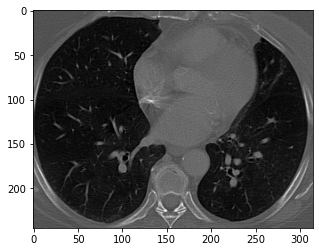

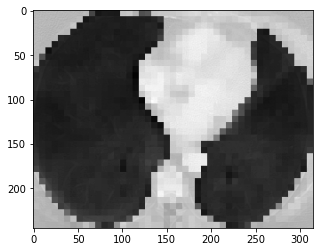

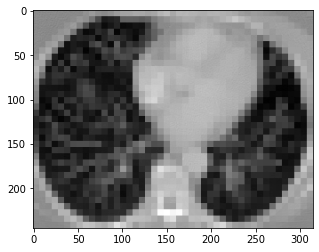

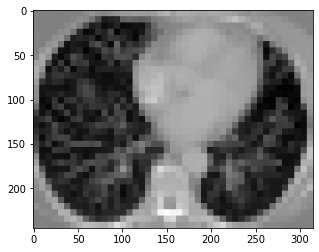

In [25]:
from ct_charachterization import run_third_algorithm


mu_3 = np.array([-850, -90, 55])
stabilized_y = run_third_algorithm(data, mu_3, non_central=True, constant_c=10, neighborhood_size=neighborhood_size)
plt.imshow(data[20, :, :], cmap='gray')
plt.show()
for j in range(len(mu_5)):
    sy = stabilized_y[..., j]
    plt.imshow(sy[20, :, :], cmap='gray')
    plt.show()




# AFTER 2 HOURS!

After 2 hours the code execution finished. (maybe my macbook pro is too weak to bear this load of computations, but I guess it is not our problem, at least for now. I can review the code to make it more efficient and faster later.)

The result of using 3d-neighborhoods is surprising. It has nothing in common with the 2d version! It seems that it is somehow better, but does not match with the paper's results again!

Let's try some minor operations to check if we can make it better or not.


In [26]:
late_result = np.sum(stabilized_y[...], axis=-1)

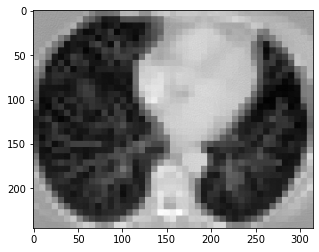

In [27]:
plt.imshow(late_result[20, :, :], cmap='gray')
plt.show()

In [28]:
late_result = np.mean(stabilized_y[...], axis=-1)

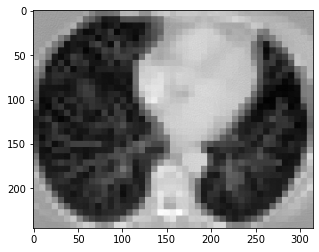

In [30]:
plt.imshow(late_result[20, :, :], cmap='gray')
plt.show()

Nope! It doesn't seem to be anything near the paper's result.

# A specefic neighborhood for each voxel

Now I think if we do not assume that the neighborhoods are fixed, and each voxel has its own specefic neighborhood, this may help the results.

In [2]:
from ct_charachterization.utility.utils import broadcast_tile, block_matrix, \
    sum_over_each_neighborhood_on_blocked_matrix, expand, contract, central_gamma_pdf

For simplicity I just define one component (hu of lung tissue).
Loading some 2d-image:

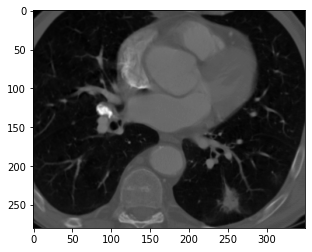

(280, 350)


In [3]:
mu_5 = np.array([-987, -810, -540, -370, -160, 0, 100, 240, 340])
img = np.load(f'''../resources/luna_cropped.npy''')
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)

The shape of the image is bigger than what my mac can afford to compute. 
OK, I crop the image to be in (128,128) shape. The size of each neighborhood will be 32/*32. Then, 16 voxels from each side of the cropped image will be inside the other's neighborhood, but they will not be considered as the center of any neighborhood.

So, we are stabilizing inside the red rectangle.

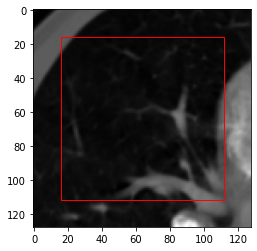

In [4]:
import matplotlib.patches as patches
fig1, ax1 = plt.subplots(1)
img = img[0:128, 0:128]
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((16,16),96,96,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()

To use the vectorization of NumPy, I have made a pair of functions: `expand` and `contract`. (This is in replace of copying a part of the image -- a single neighborhood -- each time and it may increase the ram usage but reduces the execution time.)
The image below shows the functionality of `expand`. (selects some number of center voxels and copies all its neighborhoods into a bigger matrix)

![expand](../resources/figs/expand.png)

And the `contract` function does the reverse of what `expand` does.

OK, let's go on.

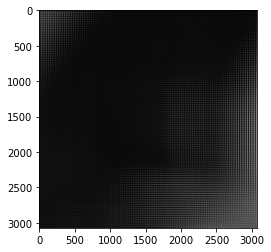

/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:10: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


iteration: 1, error: 0.1222940508373219
iteration: 2, error: 0.0


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  theta_before_expansion = np.array([initial_pi, initial_alpha, initial_beta])


iteration: 1, error: 0.26056151999985916
iteration: 2, error: 0.004762949050374908
iteration: 3, error: 0.22150351227457615
iteration: 4, error: 0.004216536692167803
iteration: 5, error: 0.18215492921491022


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:72: RuntimeWarning: overflow encountered in power
  form = np.nan_to_num(np.power(y, (alpha - 1)) * np.exp(-y / beta))
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:73: RuntimeWarning: overflow encountered in multiply
  denominator = np.power(beta, alpha) * gamma(alpha)


iteration: 6, error: 0.002417008765932697


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:53: RuntimeWarning: invalid value encountered in true_divide
  right_hand_side = (first_numerator_summation - second_numerator_summation) / denominator_summation - 1


iteration: 7, error: 0.16046781938007337
iteration: 8, error: 0.001557778723909244
iteration: 9, error: 0.16084811497236481
iteration: 10, error: 0.0011887023137218784


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:29: RuntimeWarning: invalid value encountered in true_divide
  first_local_sample_conditioned_moment[..., j] = first_numerator_summation / denominator_summation
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:30: RuntimeWarning: invalid value encountered in true_divide
  second_local_sample_conditioned_moment[..., j] = second_numerator_summation / denominator_summation


stable
smalled
(96, 96)


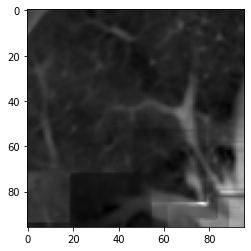

-995.2451009064481 -907.9350398099672 -495.63562120548204


In [5]:
from ct_charachterization import run_third_algorithm


y = img
big_y = expand(small_img=y, neighborhood_size=32)
big_y = big_y[16 * 32:(128-16) * 32, 16 * 32:(128-16) * 32]
plt.imshow(big_y, cmap='gray')
plt.show()
big_y_stab = run_third_algorithm(big_y, mu_5, non_central=True, constant_c=10, neighborhood_size=32)
print('stable')
y_stab = np.empty(tuple(list([96, 96]) + [len(mu_5)]), dtype=float)
for j in range(len(mu_5)):
    y_stab[..., j] = contract(big_img=big_y_stab[..., j], neighborhood_size=32)
print('smalled')
sy = y_stab[..., 0]
print(sy.shape)
plt.imshow(sy, cmap='gray')
plt.show()
print(np.min(sy) - 1030, np.mean(sy) - 1030, np.max(sy) - 1030)


(96, 96)


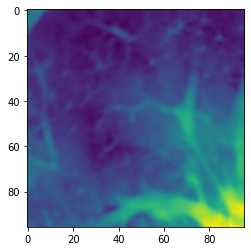

-923.3291209262999 -856.3177974972413 -665.5231813082084
(96, 96)


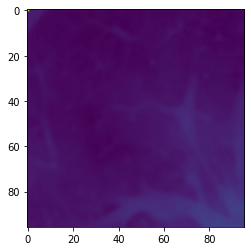

-923.3291209262999 -856.185329363895 400.0


In [15]:
from copy import deepcopy
sy = deepcopy(y_stab[..., 1])
print(sy.shape)
plt.imshow(sy)#, cmap='gray')
plt.show()
print(np.min(sy) - 1030, np.mean(sy) - 1030, np.max(sy) - 1030)
sy = deepcopy(y_stab[..., 1])
sy[0,0] = 400 - (-1030)
print(sy.shape)
plt.imshow(sy)#, cmap='gray')
plt.show()
print(np.min(sy) - 1030, np.mean(sy) - 1030, np.max(sy) - 1030)

(96, 96)


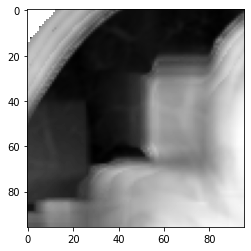

nan nan nan


In [6]:
sum_sy = np.sum(y_stab[..., :], axis=-1)
print(sum_sy.shape)
plt.imshow(sum_sy, cmap='gray')
plt.show()
print(np.min(sum_sy) - 1030, np.mean(sum_sy) - 1030, np.max(sum_sy) - 1030)

(96, 96)


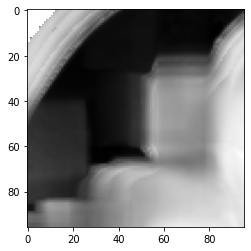

nan nan nan


In [8]:
mean_sy = np.mean(y_stab[..., :], axis=-1)
print(mean_sy.shape)
plt.imshow(mean_sy, cmap='gray')
plt.show()
print(np.min(mean_sy) - 1030, np.mean(mean_sy) - 1030, np.max(mean_sy) - 1030)

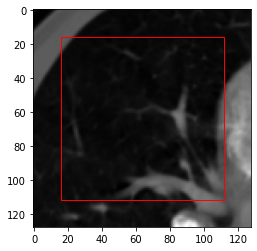

In [7]:
import matplotlib.patches as patches
fig1, ax1 = plt.subplots(1)
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((16,16),96,96,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()

# P.S.
In case you wanted to check if the theta is accurate, Now I check the distribution that algorithm models the data.

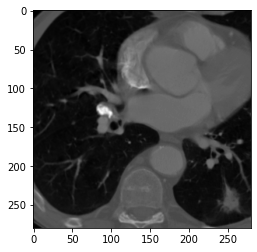

(280, 280)


In [7]:
from ct_charachterization import run_first_algorithms
img = np.load(f'''../resources/luna_cropped.npy''')[:,:280]
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)

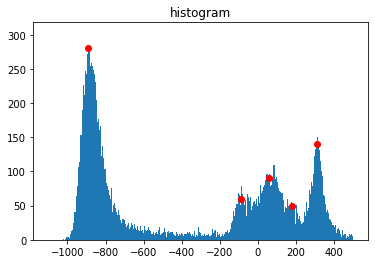

In [24]:
flat = img.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(-890, 280, "or")
ax.plot(-90, 60, "or")
ax.plot(60, 90, "or")
ax.plot(180, 50, "or")
ax.plot(310, 140, "or")
plt.title("histogram")
plt.show()

In [25]:
mu_5 = np.array([-890, -90, 60, 180, 310])
theta, gamma = run_first_algorithms(img, mu_5, non_central=True, neighborhood_size=280, tol=-1)

iteration: 1, error: 0.0912780578001684
iteration: 2, error: 2.5491931510034e-15
iteration: 3, error: 0.3077745032595292
iteration: 4, error: 2.2677319256940483e-14
iteration: 5, error: 0.31197124111084457


-904 -1920


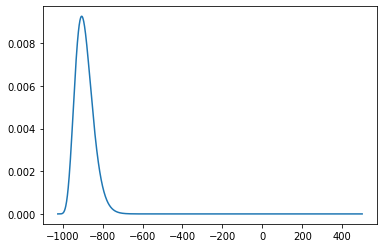

-421 -1120


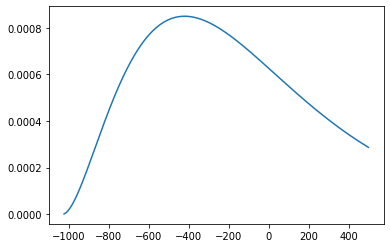

-191 -970


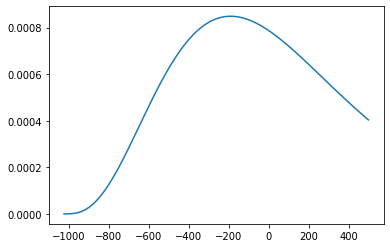

-46 -850


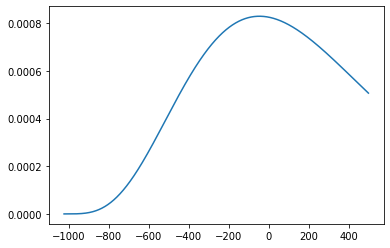

57 -720


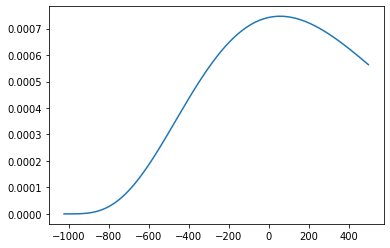

In [29]:
for j in range(len(mu_5)):
    wanted_alpha = theta[1,j]
    wanted_beta = theta[2,j]
    xs = np.arange(-1024, 500, 1) + 1030
    ys = central_gamma_pdf(xs, wanted_alpha, wanted_beta).ravel()
    plt.plot(xs - 1030, ys, '-')
    print(xs[np.argmax(ys)] -1030, mu_5[j] - 1030)
    plt.show()

It seems to be accurate, and for the last for diagrams, I think it is because of the lack of enriched data, the distributions look like that.